Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513/EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bzero}{\mathbf{0}}$


# Exercício 3: Regressão Linear & Otimização Numérica

Neste exercício você irá explorar métodos de otimização numérica para treinar um modelo de regressão linear. Em particular, você irá implementar o método do gradiente e analisar sua convergência. Além disso, você irá investigar o efeito da normalização de atributos no comportamento do método. Finalmente, você irá investigar a aplicação de regressão linear em um conjunto de dados real.

# Conjunto de dados #1

Inicialmente, utilizaremos o mesmo conjunto de dados do exercício anterior, exceto por uma escala diferente em $x$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(n_samples, x_scale=[0,1], noise=0.5):
    '''Generate univariate regression dataset'''
    x = np.sort(np.random.rand(n_samples))
    y = 6*(-1/6 + x + (x > 1/3)*(2/3-2*x) + (x > 2/3)*(2*x-4/3)) + noise*np.random.randn(n_samples)
    x = x_scale[0] + (x_scale[1]-x_scale[0])*x
    X = x.reshape(-1,1)
    return X, y

def plot_data(X, y):
    '''Plot univariate regression dataset'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    plt.plot(X[:,0],y,'b.'); plt.xlabel('x'); plt.ylabel('y');
    return

def plot_prediction(model, X, y, n_points=100):
    '''Plot dataset and predictions for a univariate regression model'''
    plot_data(X,y)
    if n_points is not None:
        xx = np.linspace(X.min(),X.max(),n_points)
        yy = model.predict(xx.reshape(-1,1))
        plt.plot(xx,yy,'r-')
    y_pred = model.predict(X)
    plt.plot(X[:,0],y_pred,'r.')
    plt.legend(['True', 'Predicted'])
    return

O conjunto de dados pode ser gerado e visualizado pelos comandos abaixo (observe a nova escala).

(30, 1) (30,)
(1000, 1) (1000,)
(1000, 1) (1000,)


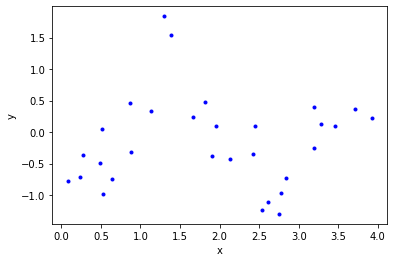

In [2]:
np.random.seed(2019*2)
X, y = gen_data(n_samples=30, x_scale=[0,4])
X_val, y_val = gen_data(n_samples=1000, x_scale=[0,4])
X_test, y_test = gen_data(n_samples=1000, x_scale=[0,4])

print(X.shape, y.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Plot only the training data!
plot_data(X,y)

## 1. Método do gradiente

Resgate a classe do modelo que você implementou no exercício anterior. Iremos reorganizá-la para permitir um método de treinamento alternativo.

1. Utilize a classe abaixo, substituindo na função `_fit_ne` a sua função `fit` implementada anteriormente, com as modificações necessárias. Note que a função `add_powers` foi eliminada (bem como o argumento `d` da inicialização do modelo), sendo substituída pela função `_add_ones` (que simplesmente adiciona uma coluna de 1's). Ou seja, nosso modelo deve implementar puramente uma regressão linear (com regularização L2), sem atributos adicionais. Caso desejemos atributos polinomiais, poderemos usar a classe `PolynomialFeatures` do sklearn. A única vantagem do nosso modelo de regressão próprio em relação ao `Ridge` é permitir utilizar um método de treinamento diferente.
1. Mova a função `mse` para fora da classe, caso contrário não poderemos acessá-la dentro de um `Pipeline`.

**Hessiana**
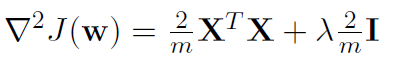

**Gradiente: Minimos quadrados com regularização l2**
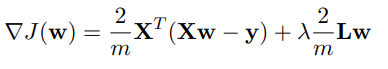

**Gradiente: Método do Gradiente com regularização l2**
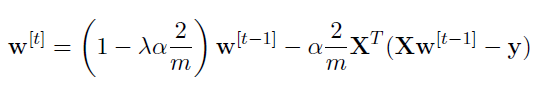

**Custo**
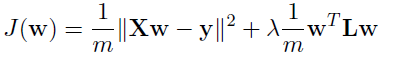

In [3]:
class Model():
    # Linear regression with L2 regularization
    def __init__(self, lamb=0, solver='ne', lr=1, maxiter=1000, tol=1e-5):
        # Initialization
        self.lamb = lamb
        self.solver = solver
        self.lr = lr
        self.maxiter = maxiter
        self.tol = tol
        return
    
    def _add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new
    
    def _fit_ne(self, X, y):
        X = self._add_ones(X)
        w = np.zeros(X.shape[1])
        
        L = np.identity(X.shape[1])
        L[0][0] = 0
        
        I = np.identity(X.shape[1])
        
        m = len(y)
        self.J_ne = []
        
        self.hessian = (2/m)*(X.T @ X) + (self.lamb*(2/m) *I)
        assert np.linalg.matrix_rank(X.T @ X + self.lamb*L) == X.shape[1], 'Singular matrix'
        gd =  (2/m)*X.T @ (X @ w - y) + (2/m)*self.lamb*L@w
        w = w - np.linalg.inv(self.hessian) @ gd
        self.w = w
        
        cost = 1/m*((np.linalg.norm(X@w -y))**2) + (self.lamb/m)*w.T@L@w
        self.J_ne.append(cost)
        return

    def _fit_gd(self, X, y):
        # Fit by gradient descent
        X = self._add_ones(X)
        w = np.zeros(X.shape[1])
        L = np.identity(X.shape[1])
        L[0][0] = 0
        self.J_gd = []
        m = len(y)
        
        for c in range(self.maxiter):
            #gd = (2/m) * X.T @ (X @ w -y) + self.lamb*(2/m)*L @ w
            gd = (2/m) * X.T @ (X @ w -y)

            w = (1 - self.lamb*self.lr*(2/m))*w - self.lr*gd
            cost = 1/m*((np.linalg.norm(X@w -y))**2) + (self.lamb/m)*w.T@L@w
            self.J_gd.append(cost)
            self.w = w
            
            if np.linalg.norm(gd) < self.tol:
                break
            
        return

    def fit(self, X, y):
        if self.solver == 'gd':
            self._fit_gd(X, y)
        elif self.solver == 'ne':
            self._fit_ne(X, y)
        else:
            raise RuntimeError('Unknown solver')
        return self

    def predict(self, X):
        X = self._add_ones(X)
        y_pred = X @ self.w
        return y_pred

def mse(model, X, y):
    m = len(y)
    mse = ((1/m)* np.sum(((model.predict(X) - y)**2)))
    return mse

def mape(model, X, y):
    p = y
    p_pred = model.predict(X)
    return  (np.mean(np.abs((p-p_pred)/p)))*100

3. Modifique a função `_fit_ne` para calcular também a matriz hessiana da função custo (regularizada), guardando-a na variável `self.hessian`. Em seguida, após o treinamento usando a solução analítica, estime o grau de condicionamento da hessiana utilizana a função `np.linalg.cond()`.
1. Complete a função `_fit_gd` implementando o método do gradiente. Utilize os parâmetros `self.lr` (taxa de aprendizado), `self.maxiter` (número máximo de iterações) e `self.tol` (critério de parada para a norma do gradiente), e assuma como ponto inicial $\bw = (0,\ldots,0)$. Além de calcular `self.w`, sua função deve criar também uma lista, `self.J_history`, contendo os valores da função custo (regularizada) a cada iteração, a qual será usada para monitorar o treinamento e analisar a taxa de aprendizado.
1. Treine o modelo sem regularização usando `solver='gd'`, trace o gráfico de `J_history` e escolha uma boa taxa de aprendizado. Quantas iterações foram necessárias para convergência?
1. Calcule o MSE de treinamento e de validação e compare-os com os obtidos pela solução analítica. Compare também os vetores $\bw$ das duas soluções. (Obs: a saída da célula 5 está mostrada apenas para ilustração. Não é necessário reproduzir exatamente o mesmo texto/gráfico.)
1. (OPCIONAL) O que acontece com o erro de validação à medida que a taxa de aprendizado é reduzida? Como podemos interpretar esse fenômeno?

**Resposta do professor:**
- w = [-0.20189161  0.02333163]
- Train MSE: 0.517264
- Val MSE: 0.601059
- Condition number: 24.959359

**Minha resposta:**

In [4]:
# Normal equation
model = Model(solver = 'ne')
model.fit(X,y)
model.fit(X, y)
J_ne = model.J_ne
print('w =', model.w)
print('Train MSE: %f' % mse(model, X, y))
print('Val MSE: %f' % mse(model, X_val, y_val))
print('Condition number: %f' % np.linalg.cond(model.hessian))

w = [-0.20189161  0.02333163]
Train MSE: 0.517264
Val MSE: 0.601059
Condition number: 24.959359


**Resposta do professor:**

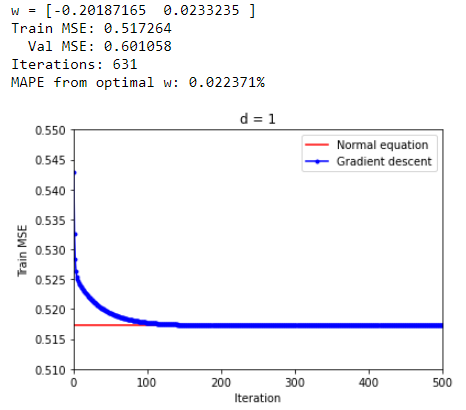

**Minha resposta:**

In [5]:
#Gradient Descent
model = Model(solver = 'gd', lr=1e-1, maxiter=1000)
model.fit(X,y)
model.fit(X, y)
print('w =', model.w)
print('Train MSE: %f' % mse(model, X, y))
print('Val MSE: %f' % mse(model, X_val, y_val))
print(f'Iterations: {len(model.J_gd)}')
print(mape(model,X,y))

w = [-0.2018722   0.02332372]
Train MSE: 0.517264
Val MSE: 0.601058
Iterations: 197
123.46660127755706


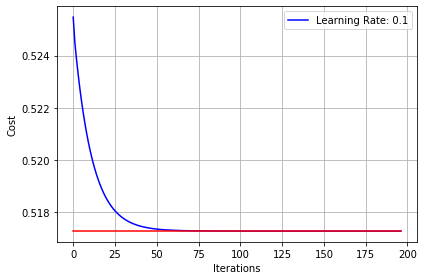

In [6]:
values = np.arange(len(model.J_gd))
J_ne_values = np.ones(len(model.J_gd))*J_ne
plt.plot(values, model.J_gd,'b')
plt.plot(values,J_ne_values,'r')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend([f'Learning Rate: {model.lr}'])
plt.grid()
plt.tight_layout()

## 2. Adicionando atributos

1. Adicione atributos polinomiais de grau `d=2` usando o transformador `PolynomialFeatures`. Em seguida, repita o treinamento via solução analítica e estimação do grau de condicionamento da hessiana.
1. Repita o treinamento usando método do gradiente (incluindo gráfico da função custo) e verifique a dificuldade de convergência. Por que isso ocorre? Foi necessário alterar a taxa de aprendizado? E o número máximo de iterações?
1. Assim como anteriormente, compare o MSE e o $\bw$ obtidos com os da solução analítica.
1. Repita os itens anteriores para `d=3`.

#### Dica

- Não há necessidade de incluir o termo constante nos atributos adicionados, uma vez que o modelo de regressão linear já implementa a adição de coluna de 1's. Assim, utilize `PolynomialFeatures(d, include_bias=False)`.
- Normalmente, é conveniente utilizar a função `make_pipeline` para combinar pré-processamento (transformação de atributos) e modelo de aprendizado (estimador) em um único modelo. Além de deixar o código mais compacto, essa metodologia ajuda a evitar erros de vazamento de informação entre teste e treinamento, pois garante que o transformador será treinado somente com os dados de treinamento. No entanto, como o nosso foco aqui é o treinamento, é mais conveniente primeiramente aplicar a transformação de atributos explicitamente no conjunto de dados, obtendo um conjunto transformado (aqui com sufixo `_new`), o qual é então entregue ao modelo de aprendizado. Embora não seja o caso aqui, essa abordagem também é mais eficiente quando o pré-processamento é particularmente complexo e serão realizados múltiplos treinamentos, assim o pré-processamento só precisa ser realizado uma vez.

**Resposta do professor:**
- w = [-0.35250239  0.26848578 -0.06441263]
- Train MSE: 0.511996
- Val MSE: 0.611803
- Condition number: 955.280910

**Minha resposta:**

In [7]:
from sklearn.preprocessing import PolynomialFeatures

<center> d = 2

In [8]:
# Feature transformation
d = 2
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.transform(X_val)
# Normal equation
model = Model()
model.fit(X_new, y)
J_ne = model.J_ne

print('w = ',model.w)
print('Train MSE: %f' % mse(model, X_new, y))
print('Val MSE: %f' % mse(model, X_val_new, y_val))
print('Condition number: %f' % np.linalg.cond(model.hessian))

w =  [-0.35250239  0.26848578 -0.06441263]
Train MSE: 0.511996
Val MSE: 0.611803
Condition number: 955.280910


In [9]:
# Gradient descent
model = Model(solver = 'gd', lr = 2e-2, maxiter = 4500)
model.fit(X_new, y)
print('w = ',model.w)
print('Train MSE: %f' % mse(model, X_new, y))
print('Val MSE: %f' % mse(model, X_val_new, y_val))
print(f'Iterations: {len(model.J_gd)}')

w =  [-0.35244342  0.26841033 -0.06439477]
Train MSE: 0.511996
Val MSE: 0.611798
Iterations: 4097


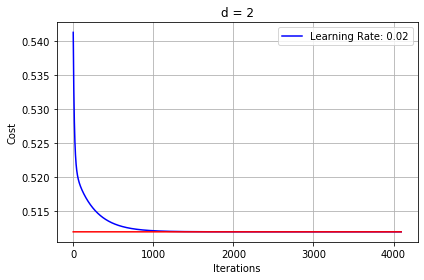

In [10]:
values = np.arange(len(model.J_gd))
J_ne_values = np.ones(len(model.J_gd))*J_ne
plt.title('d = 2')
plt.plot(values, model.J_gd,'b')
plt.plot(values,J_ne_values,'r')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend([f'Learning Rate: {model.lr}'])
plt.grid()
plt.tight_layout()

**<center>2.3. Por que isso ocorre? Foi necessário alterar a taxa de aprendizado? E o número máximo de iterações?**

Aumentando o grau do polinomio dificulta a convergencia. Foi necessário reduzir o valor da taxa de aprendizado e aumentar o numero máximo de iterações para aproximar ao mínimo global.

**<center>2.4. Repita os itens anteriores para d=3**

In [11]:
# Feature transformation
d = 3
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.transform(X_val)
# Normal equation
model = Model()
model.fit(X_new, y)
J_ne = model.J_ne

print('w = ',model.w)
print('Train MSE: %f' % mse(model, X_new, y))
print('Val MSE: %f' % mse(model, X_val_new, y_val))
print('Condition number: %f' % np.linalg.cond(model.hessian))

w =  [-1.57554215  3.91985205 -2.32464225  0.37687856]
Train MSE: 0.325498
Val MSE: 0.334947
Condition number: 63865.336863


In [12]:
# Gradient descent
model = Model(solver = 'gd', lr = 9e-4, maxiter = 620000)
model.fit(X_new, y)
print('w = ',model.w)
print('Train MSE: %f' % mse(model, X_new, y))
print('Val MSE: %f' % mse(model, X_val_new, y_val))
print(f'Iterations: {len(model.J_gd)}')

w =  [-1.57534334  3.91934363 -2.32435417  0.37683337]
Train MSE: 0.325498
Val MSE: 0.334952
Iterations: 616418


C:\Users\victo\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\victo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


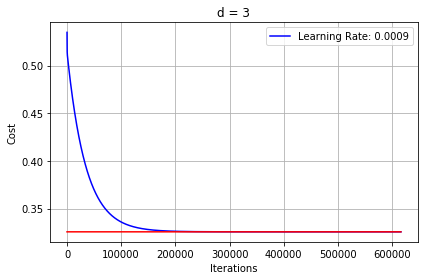

In [13]:
values = np.arange(len(model.J_gd))
J_ne_values = np.ones(len(model.J_gd))*J_ne
plt.title('d = 3')
plt.plot(values, model.J_gd,'b')
plt.plot(values,J_ne_values,'r')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend([f'Learning Rate: {model.lr}'])
plt.grid()
plt.tight_layout()

## 3. Escalonamento de atributos

Implemente a normalização (escalonamento) de atributos conforme vista em sala, a qual consiste de:
 - Subtração da média do atributo, para que passe a ter média nula
 - Divisão pelo desvio padrão do atributo, para que passe a ter variância unitária
 
Esse tipo de normalização também é chamado em alguns contextos de padronização (*standardization*), no sentido de resultar na mesma média (0) e variância (1) de uma variável aleatória gaussiana padrão (*standard*), em contraste com outros tipos de normalização (por exemplo, reescalonamento para a escala [0,1]).

1. Para isso, complete a classe abaixo. Caso deseje confirmar se sua implementação está correta, compare com o transformador `StandardScaler` do módulo `sklearn.preprocessing`.
1. Após implementar corretamente, verifique que seu escalonador funciona corretamente em um pipeline do `sklearn`; isto é, combine todas as etapas de pré-processamento (transformação de atributos e escalonamento) usando `make_pipeline`. Em seguida, você pode ignorar sua implementação e passar a usar o `StandardScaler`.
1. Refaça os mesmos passos da seção anterior (2.1-2.4) e compare os resultados e o comportamento do algoritmo. Explique.
1. Neste problema, em qual posição o escalonador funciona melhor, antes ou depois da adição de atributos? Cite as evidências que você observou.
1. O uso do escalonador tem impacto do desempenho da solução analítica? Por quê?
1. (OPCIONAL) Experimente outros escalonadores do `sklearn`, como `MinMaxScaler` e `MaxAbsScaler`, e compare o desempenho obtido.

#### Dicas

- Funções úteis:

```python
np.mean(axis=0), np.std(axis=0)
```

- Revise as propriedades de broadcasting do NumPy, em particular em operações envolvendo matrizes e arrays 1D.
- Para depurar possíveis erros, lembre-se de verificar o `shape` dos arrays envolvidos.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Compute and store scaler parameters
        self.media = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self, X, y=None):
        # Scale features
        self.fit(X)
        X_new = (X-self.media)/self.std
        return X_new

A = np.array([[1, 1, 1], [2, 4, 8], [3, 9, 27], [4, 16, 64]])

# Pego os valores de media e std armazenados em fit e jogo na fórmula de normalização de atributos(transform)
Mystandardize = MyStandardScaler()
print(f"Transform:\n{Mystandardize.transform(A)}\n")
print(f"Media: {Mystandardize.media}")

Transform:
[[-1.34164079 -1.14458618 -0.98184354]
 [-0.4472136  -0.61631563 -0.69547251]
 [ 0.4472136   0.26413527  0.08182029]
 [ 1.34164079  1.49676654  1.59549575]]

Media: [ 2.5  7.5 25. ]


**<center>3.1. compare com o transformador StandardScaler do módulo sklearn.preprocessing.**

In [15]:
from sklearn.preprocessing import StandardScaler
norm_sk = StandardScaler()
norm_sk.fit(A)
print(f"Mean: {norm_sk.mean_}\n")
print(f"Transform:\n{norm_sk.transform(A)}")

Mean: [ 2.5  7.5 25. ]

Transform:
[[-1.34164079 -1.14458618 -0.98184354]
 [-0.4472136  -0.61631563 -0.69547251]
 [ 0.4472136   0.26413527  0.08182029]
 [ 1.34164079  1.49676654  1.59549575]]


**<center>3.2. Após implementar corretamente, verifique que seu escalonador funciona corretamente em um pipeline do sklearn; isto é, combine todas as etapas de pré-processamento (transformação de atributos e escalonamento) usando make_pipeline. Em seguida, você pode ignorar sua implementação e passar a usar o StandardScaler.**

Verificando o funcionamento do escalonador utilizando Pipeline:

In [16]:
from sklearn.pipeline import make_pipeline, Pipeline

In [17]:
pipe = Pipeline([('scaler', MyStandardScaler())])

In [18]:
pipe

Pipeline(memory=None, steps=[('scaler', MyStandardScaler())], verbose=False)

In [19]:
#pipe.fit(X)
pipe.transform(A)

array([[-1.34164079, -1.14458618, -0.98184354],
       [-0.4472136 , -0.61631563, -0.69547251],
       [ 0.4472136 ,  0.26413527,  0.08182029],
       [ 1.34164079,  1.49676654,  1.59549575]])

**<center>Implementação**

In [20]:
def standardized_ne(d, X,y,X_val,y_val,lr=1,maxiter=1000):
    prep = make_pipeline(PolynomialFeatures(d,include_bias=False), StandardScaler())
    
    X_new = prep.fit_transform(X)
    X_val_new = prep.transform(X_val)
    
    model = Model(solver='ne',maxiter=maxiter,lr=lr)
    model.fit(X_new, y)
    J_ne = model.J_ne

    print('w = ',model.w)
    print('Train MSE: %f' % mse(model, X_new, y))
    print('Val MSE: %f' % mse(model, X_val_new, y_val))
    print('Condition number: %f' % np.linalg.cond(model.hessian))
    return

def standardized_gd(d, X,y,X_val,y_val,lr=1,maxiter=1000):
    prep = make_pipeline(PolynomialFeatures(d,include_bias=False), StandardScaler())
    
    X_new = prep.fit_transform(X)
    X_val_new = prep.transform(X_val)
    
    # Gradient descent
    model = Model(solver = 'gd', lr = lr, maxiter=maxiter)
    model.fit(X_new, y)
    J_gd = model.J_gd

    print('w = ',model.w)
    print('Train MSE: %f' % mse(model, X_new, y))
    print('Val MSE: %f' % mse(model, X_val_new, y_val))
    print(f'Iterations: {len(model.J_gd)}')
    
    values = np.arange(len(J_gd))
    plt.title(f'd = {d}')
    plt.plot(values, model.J_gd,'b')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend([f'Learning Rate: {model.lr}'])
    plt.grid()
    plt.tight_layout()
    return

**=========================================================================================================================**

**<center>d = 1**

**=========================================================================================================================**

**Valores antigos - ne:**
- w = [-0.20189161  0.02333163]
- Train MSE: 0.517264
- Val MSE: 0.601059
- Condition number: 24.959359

In [21]:
standardized_ne(1,X,y,X_val,y_val)

w =  [-0.15760574  0.02642926]
Train MSE: 0.517264
Val MSE: 0.601059
Condition number: 1.000000


=========================================================================================================================

**Valores antigos - gd:**
- w = [-0.2018722   0.02332372]
- Train MSE: 0.517264
- Val MSE: 0.601058
- Iterations: 197
- lr=1e-1, maxiter=1000

w =  [-0.15760222  0.02642867]
Train MSE: 0.517264
Val MSE: 0.601058
Iterations: 48


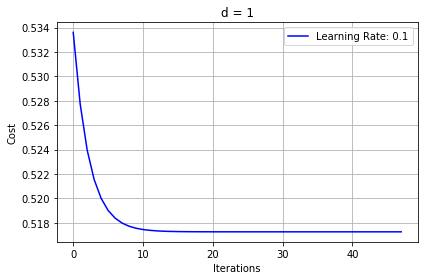

In [22]:
standardized_gd(1,X,y,X_val,y_val, lr=1e-1)

**=========================================================================================================================**

**<center>d = 2**

**=========================================================================================================================**

**Valores antigos - ne:**
- w =  [-0.35250239  0.26848578 -0.06441263]
- Train MSE: 0.511996
- Val MSE: 0.611803
- Condition number: 955.280910

**Valores atuais - ne:**

In [23]:
standardized_ne(2,X,y,X_val,y_val)

w =  [-0.15760574  0.30413138 -0.28703144]
Train MSE: 0.511996
Val MSE: 0.611803
Condition number: 60.533170


=========================================================================================================================

**Valores antigos - gd:**
- w =  [-0.35244342  0.26841033 -0.06439477]
- Train MSE: 0.511996
- Val MSE: 0.611798
- Iterations: 4097
- lr = 2e-2, maxiter = 4500

**Valores atuais - gd:**

w =  [-0.15760574  0.29816541 -0.28106547]
Train MSE: 0.511998
Val MSE: 0.611473
Iterations: 3000


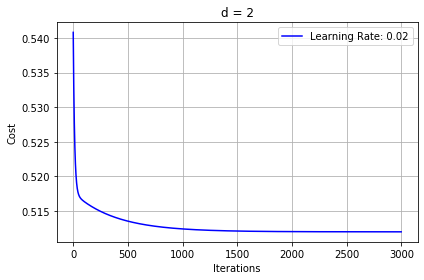

In [24]:
standardized_gd(2,X,y,X_val,y_val, lr=2e-2,maxiter=3000)

**=========================================================================================================================**

**<center>d = 3**

**=========================================================================================================================**

**Valores antigos - ne:**
- w =  [-1.57554215  3.91985205 -2.32464225  0.37687856]
- Train MSE: 0.325498
- Val MSE: 0.334947
- Condition number: 63865.336863

**Valores atuais -ne:**

In [25]:
standardized_ne(3,X,y,X_val,y_val)

w =  [ -0.15760574   4.44027247 -10.35892185   6.17476069]
Train MSE: 0.325498
Val MSE: 0.334947
Condition number: 2500.073501


=========================================================================================================================

**Valores antigos - gd:**
- w =  [-1.57534334  3.91934363 -2.32435417  0.37683337]
- Train MSE: 0.325498
- Val MSE: 0.334952
- Iterations: 616418
- lr = 9e-4, maxiter = 620000

**Valores atuais - gd:**

w =  [-0.15760574  4.16962583 -9.72277231  5.79476493]
Train MSE: 0.326222
Val MSE: 0.339552
Iterations: 6000


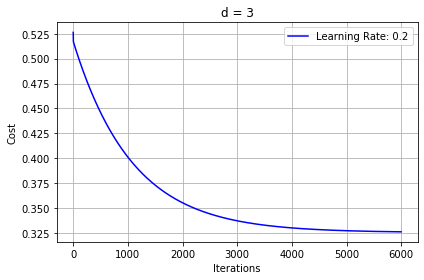

In [26]:
standardized_gd(3,X,y,X_val,y_val, lr=2e-1,maxiter=6000)

**=========================================================================================================================**

**Refaça os mesmos passos da seção anterior (2.1-2.4) e compare os resultados e o comportamento do algoritmo. Explique.**
O método do gradiente permite reduzir o numero de iterações. O método analítico apresentou valores bem menores de condition number, além de convergir muito mais rápido do que o método do gradiente.

**Neste problema, em qual posição o escalonador funciona melhor, antes ou depois da adição de atributos? Cite as evidências que você observou.** Depois da adição de atributos. Para o método de newton, os valores de MSE foram bem aproximados do método analítico. As iterações utilizando o método do gradiente foram bem menores. Percebe-se que quanto maior o grau, torna-se mais complexo de convergir até o mínimo global.

**O uso do escalonador tem impacto do desempenho da solução analítica? Por quê?**Sim. Antes os antributos apresentavam escalas diferentes. Após normalizar, cada atributo passa a ter aproximadamente a mesma escala, priorizando os valores dos atributos. Pode-se analisar que, após o condicionamento, o gradiente apresenta menor dificuldade para convergir.

## 4. Ainda mais atributos

1. Adicione atributos polinomiais de grau ainda maior (ex: d=4, d=5). O que você observa?
1. Você recomendaria o método do gradiente para um problema desse tipo? Ou seria melhor usar um método de segunda ordem? Explique.

**<center>d = 4**

In [27]:
standardized_ne(4,X,y,X_val,y_val)

w =  [ -0.15760574   4.39361861 -10.15559895   5.88469504   0.13391458]
Train MSE: 0.325492
Val MSE: 0.335070
Condition number: 85117.554639


w =  [-0.15760574  2.99481152 -4.53902172 -1.66943629  3.4707182 ]
Train MSE: 0.330208
Val MSE: 0.346170
Iterations: 5000


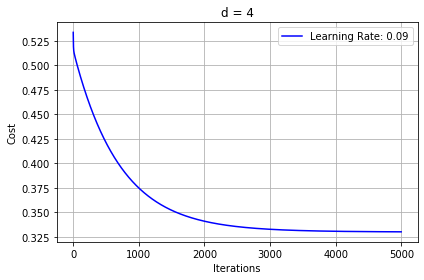

In [28]:
standardized_gd(4,X,y,X_val,y_val, lr=9e-2,maxiter=5000)

**<center>d = 6**

In [29]:
standardized_ne(6,X,y,X_val,y_val)

w =  [-1.57605735e-01 -6.86702494e+00  6.69209371e+01 -1.84682744e+02
  2.01576953e+02 -7.88219232e+01  2.00467308e+00]
Train MSE: 0.184140
Val MSE: 0.312047
Condition number: 111117893.791502


w =  [ -0.15760574  -0.38277974  19.17711622 -48.02558597  14.13100291
  44.25303465 -28.98890834]
Train MSE: 0.203361
Val MSE: 0.290106
Iterations: 700000


C:\Users\victo\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\victo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


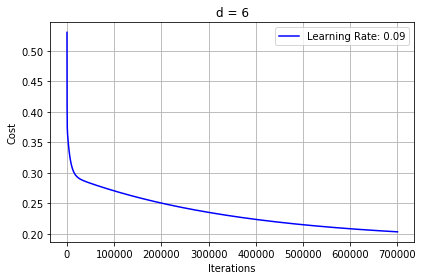

In [30]:
standardized_gd(6,X,y,X_val,y_val, lr=9e-2,maxiter=700000)

**1. O que você observa? Você recomendaria o método do gradiente para um problema desse tipo? Ou seria melhor usar um método de segunda ordem? Explique.** Quanto maior o grau, maior a dificuldade para convergir. Não recomendaria o método do gradiente. O método de segunda ordem seria bem melhor, pela aproximação quadrática utiliza menos recurso computacional e o valor é satisfatório.

# 5. Conjunto de dados #2

O segundo conjunto de dados que usaremos consiste de dados sobre a venda de casas em King County, USA, entre maio de 2014 e maio de 2015. O objetivo é prever o preço de venda a partir de informações sobre a casa. 

In [31]:
import pandas as pd
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Como variável de saída, $y$, utilize o **logaritmo** neperiano do preço de venda , `price`, i.e., `np.log(price)`. Desta forma o erro na predição de $y$ será função do erro _relativo_ na predição do preço, evitando dar peso excessivo aos preços mais altos. Por exemplo, quando a função perda é o erro quadrático, a perda equivale aproximadamente ao quadrado do erro relativo:

$L(y,\hat{y}) = (\hat{y} - y)^2 = (\log(\hat{p}) - \log(p))^2 = (\log(\hat{p}/p))^2 = (\log(1 + (\hat{p}-p)/p))^2 \approx ((\hat{p}-p)/p)^2$


Como atributos, utilize apenas as 4 colunas após o preço de venda, i.e.:
- `bedrooms`: número de quartos
- `bathrooms`: número de quartos, em múltiplos de 1/4 (https://www.realtor.com/advice/buy/what-is-a-half-bath/)
- `sqft_living`: área da casa, em ft${^2}$
- `sqft_lot`: área do lote, em ft${^2}$

## Preparação

1. Prepare e divida o conjunto de dados aleatoriamente em conjuntos de treinamento, validação e teste, nas proporções 60%, 20% e 20%, respectivamente. Para isso, utilize a função `sklearn.model_selection.train_test_split()`.
1. Como função perda para o treinamento, utilize o erro quadrático, e, como métrica de avaliação do modelo, utilize a raiz quadrada do erro quadrático médio. Ambos são equivalentes, mas o segundo resulta em valores numa escala mais agradável para análise e mais fácil de interpretar. Adicionalmente, utilize como métrica de avaliação o [erro percentual absoluto médio](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (MAPE) do preço de venda (i.e., da variável original `price`, **não** da variável `y = np.log(price)`). Esta métrica é ainda mais fácil de interpretar.

In [32]:
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = np.log(df['price']).to_numpy()
print(X.shape, y.shape)

(21560, 4) (21560,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


In [34]:
def rmse(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y_pred,y))

In [35]:
def mape(model, X, y):
    p = y
    p_pred = model.predict(X)
    return  (np.sum(np.abs((p-p_pred)/p))/len(p))*100

## Exploração dos dados

Antes de escolher e começar a treinar um modelo, é útil fazer uma breve exploração dos dados. (Foi dessa exploração inicial que surgiu a ideia, por exemplo, de remover outliers, com aqueles valores específicos.) 

3. Para cada atributo, trace o gráfico da variável de saída em função do atributo, **sobre o conjunto de treinamento** (não trace gráficos sobre o conjunto de teste para evitar vazamento de informação). Observe as escalas das variáveis envolvidas e analise se há alguma dependência aparente entre as variáveis. Intuitivamente, qual atributo parece ser mais preditivo do preço do venda?

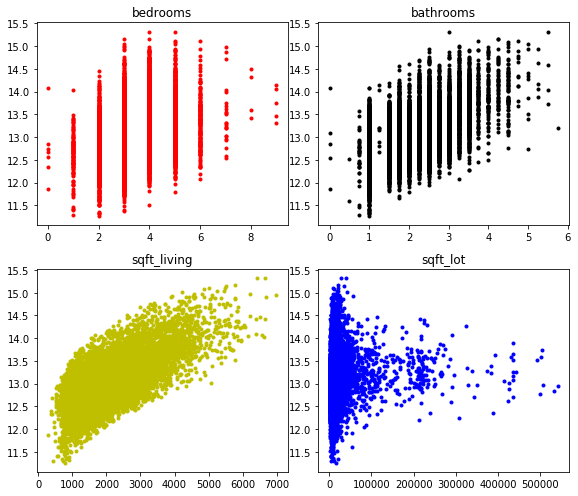

In [36]:
f, axs = plt.subplots(2,2, figsize=(8, 7))

axs[0][0].plot(X_train[:,0],y_train, 'r.')
axs[0][0].set_title('bedrooms')
axs[0][1].plot(X_train[:,1],y_train, 'k.')
axs[0][1].set_title('bathrooms')
axs[1][0].plot(X_train[:,2],y_train, 'y.')
axs[1][0].set_title('sqft_living')
axs[1][1].plot(X_train[:,3],y_train, 'b.')
axs[1][1].set_title('sqft_lot')

plt.tight_layout()

## Regressão linear

4. Inicialmente você deve treinar um modelo de regressão linear sem regularização e calcular o desempenho da predição (RMSE e MAPE) sobre o conjunto de treinamento e sobre o conjunto de validação. Fique à vontade para usar as funções do `sklearn`, não há necessidade de usar o método do gradiente.
1. Você diria que o modelo treinado sofre de underfitting, overfitting ou nenhum dos dois? Explique.
1. Analisando o vetor de pesos do modelo treinado (`model.coef_`), qual atributo você diria que é o mais importante para a predição? Por quê? Esta observação confirma a sua hipótese do item anterior? Explique.

#### Dica
- Para acessar o regressor dentro de um *pipeline* do sklearn, inicialize-o fora do *pipeline* ou acesse-o via `model.steps[-1][1]`.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [38]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

In [40]:
print(f"MSE Train: {rmse(model,X_train,y_train)}")
print(f"MAPE Train: {mape(model,X_train,y_train)}\n")
print(f"MSE Val: {rmse(model,X_val, y_val)}")
print(f"MAPE Val: {mape(model,X_val,y_val)}")

MSE Train: 0.3730442212736104
MAPE Train: 2.323080739214794

MSE Val: 0.3775202582515239
MAPE Val: 2.352042573743753


In [41]:
def plot_train(X,y,y_pred,title = 'Train predicted - Bedroms', xlabel ='Bedroms', ylabel= 'Price' ):   
    plt.plot(X, y, 'r.')
    plt.plot(X, train_pred, 'b.')
    plt.legend(['Real','Previsto'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return

def plot_val(X,y,y_pred,title = 'Val predicted - Bedroms', xlabel ='Bedroms', ylabel= 'Price' ):   
    plt.plot(X, y, 'r.')
    plt.plot(X, val_pred, 'b.')
    plt.legend(['Real','Previsto'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return

#### Plot Bedroms

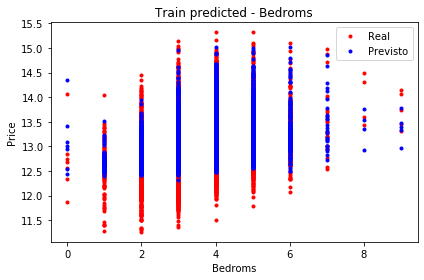

In [42]:
plot_train(X_train[:,0],y_train,train_pred)

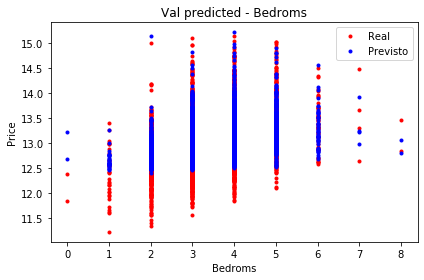

In [43]:
plot_val(X_val[:,0], y_val, val_pred)

#### Plot Bathrooms

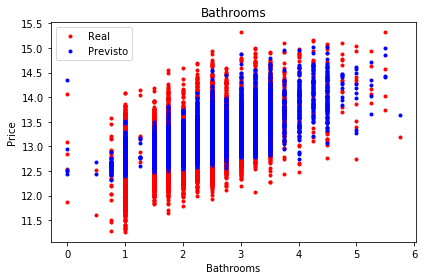

In [44]:
plot_train(X_train[:,1],y_train,train_pred, title = 'Bathrooms', xlabel = 'Bathrooms')

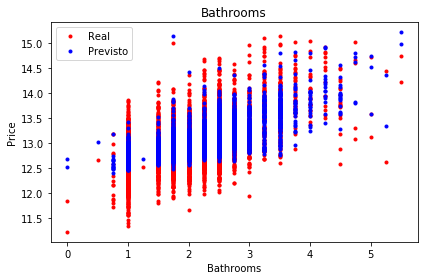

In [45]:
plot_val(X_val[:,1], y_val, val_pred, title = 'Bathrooms', xlabel = 'Bathrooms')

#### Plot sqft_living

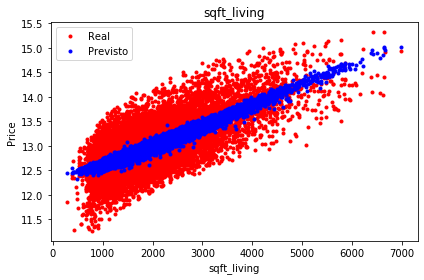

In [46]:
plot_train(X_train[:,2], y_train,train_pred, title = 'sqft_living', xlabel = 'sqft_living')

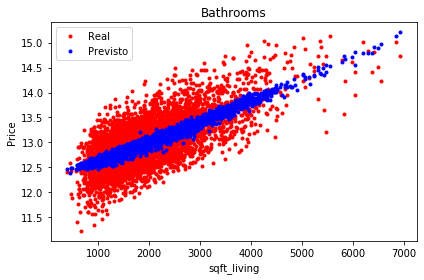

In [47]:
plot_val(X_val[:,2], y_val, val_pred, title = 'Bathrooms', xlabel = 'sqft_living')

#### Plot sqft_lot

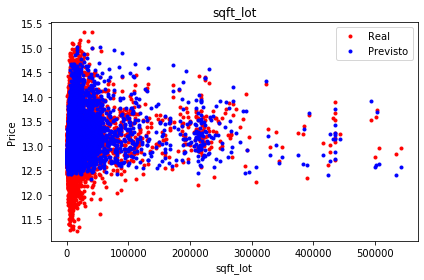

In [48]:
plot_train(X_train[:,3], y_train,train_pred, title = 'sqft_lot', xlabel = 'sqft_lot')

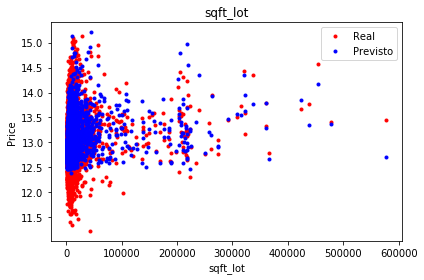

In [49]:
plot_val(X_val[:,3], y_val, val_pred, title = 'sqft_lot', xlabel = 'sqft_lot')

**Você diria que o modelo treinado sofre de underfitting, overfitting ou nenhum dos dois? Explique.**
Nenhum dos dois. Os modelos de treino e validação apresentam valores de MSE bem próximos.
**<p>Analisando o vetor de pesos do modelo treinado (model.coef_), qual atributo você diria que é o mais importante para a predição? Por quê? Esta observação confirma a sua hipótese do item anterior? Explique.** Bathrooms, devido ao maior coeficiente de determinação. Confirma, pois os dados de validação tenderam a aproximar sem precisar utilizar métodos de regularização.

In [50]:
print(f"Bedroms: {model.coef_[0]}")
print(f"Bathrooms: {model.coef_[1]}")
print(f"sqft_living: {model.coef_[2]}")
print(f"sqft_lot: {model.coef_[3]}")

Bedroms: -0.077113273618179
Bathrooms: 0.052419478598470494
sqft_living: 0.0004212568862957101
sqft_lot: -4.5131645281671524e-07


## Aprimorando o modelo

7. Usando o que vimos até agora na disciplina, tente ao máximo melhorar o desempenho do modelo neste conjunto de dados. Reporte o desempenho obtido (RMSE e MAPE).

#### Dica:
- Reveja os conceitos aprendidos na Aula 2 e no Exercício 2.
- Se desejar aplicar alguma transformação de atributos "customizada", você tem duas opções: criar um transformador customizado do `sklearn` e integrá-lo em uma *pipeline* (ver último item opcional do Exercício 2), ou, *somente se for uma transformação que não envolve estimação de parâmetros*, você pode aplicá-la diretamente a todo o conjunto de dados (matrix $\bX$ antes do *split*).

**<center>Modelo de Regressão**

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [31]:
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = np.log(df['price']).to_numpy()
print(X.shape, y.shape)

(21560, 4) (21560,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


In [33]:
from ipywidgets import interact

@interact(degree = (1,12,1))
def poly(degree):
    poly = PolynomialFeatures(degree = degree)
    Xpoly_train = poly.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(Xpoly_train,y_train)
        
    y_pred = model.predict(Xpoly_train)
    #plt.plot(Xpoly_train,Xpoly_train,'b')  
    plt.plot(Xpoly_train,y_train,'b.')
    plt.plot(Xpoly_train,y_pred,'r.')  
    print(f'RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
    #plot_prediction(model, X_train, y_train, n_points=100) 

interactive(children=(IntSlider(value=6, description='degree', max=12, min=1), Output()), _dom_classes=('widge…

In [37]:
poly = PolynomialFeatures(degree = 3)
Xpoly_train = poly.fit_transform(X_train)
Xpoly_val = poly.fit_transform(X_val)

model = LinearRegression()
model.fit(Xpoly_train,y_train)
y_val_pred = model.predict(Xpoly_val)
print(f'Val RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}')

Val RMSE: 0.3776119747392318


**<center>Modelo de Regressão + normalização**

In [38]:
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = np.log(df['price']).to_numpy()
print(X.shape, y.shape)

(21560, 4) (21560,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


### PRECISO CORRIGIR ESSA SESSÃO. TENHO QUE ESCALONAR O EXERCÍCIO ANTES DA REGRESSÃO.

In [40]:
poly = PolynomialFeatures(degree = 3)
X_poly_train = poly.fit_transform(X_train)
X_poly_val = poly.fit_transform(X_val)

In [41]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_poly_train)
X_val_norm = scaler.fit_transform(X_poly_val)

In [42]:
model = LinearRegression()
model.fit(X_train_norm,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
y_train_pred = model.predict(X_train_norm)
y_val_pred = model.predict(X_val_norm)

In [44]:
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}")
print(f"Val RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}")

Train RMSE: 0.36900276100994445
Val RMSE: 0.37702011901543264


**<center>Ridge**

In [45]:
import pandas as pd
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
print(df.shape)

(21613, 21)


In [46]:
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = np.log(df['price']).to_numpy()
print(X.shape, y.shape)

(21560, 4) (21560,)


In [47]:
from sklearn.linear_model import Ridge

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


In [49]:
poly = PolynomialFeatures(degree = 3)
X_train = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)
X_test = poly.fit_transform(X_test)

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.87308e-56): result may not be accurate.
  overwrite_a=True).T
C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.87308e-46): result may not be accurate.
  overwrite_a=True).T
C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.87308e-36): result may not be accurate.
  overwrite_a=True).T
C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.85304e-26): result may not be accurate.
  overwrite_a=True).T


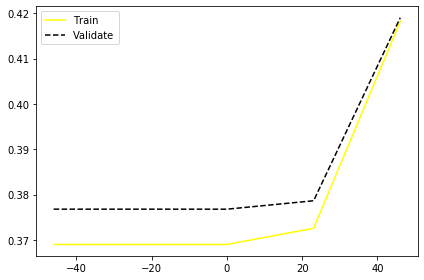

In [50]:
alphas = 10**np.linspace(-20,20,num = 5)
alphas

J_train = []
J_val = []

for c in range(len(alphas)):
    lamb = alphas[c]
    ridge = Ridge(alpha = lamb)
    
    ridge.fit(X_train, y_train)
    
    ridge_train_pred = ridge.predict(X_train)
    ridge_val_pred = ridge.predict(X_val)
    
    new_J_train = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
    new_J_val = np.sqrt(mean_squared_error(y_val, ridge_val_pred))
    
    J_train.append(new_J_train)
    J_val.append(new_J_val)

ln_alpha = np.log(alphas)
plt.plot(ln_alpha,J_train,'yellow')
plt.plot(ln_alpha,J_val,'k--')

plt.legend(['Train','Validate'])
plt.tight_layout()

In [51]:
print(f"Menor valor de validação: {round(min(J_val),3)}")

Menor valor de validação: 0.377


In [52]:
index_min_MSE = J_val.index(min(J_val))
index_min_MSE

2

In [53]:
alphas[index_min_MSE]
min_lambda = alphas[index_min_MSE]
min_lambda

1.0

**<center>Ridge + Normalização**

In [56]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.fit_transform(X_val)

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.88459e-26): result may not be accurate.
  overwrite_a=True).T


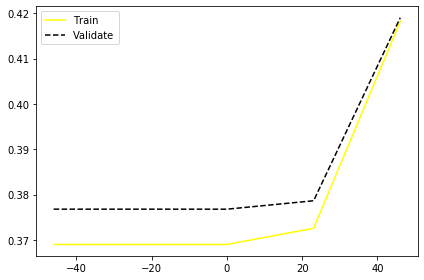

In [57]:
alphas = 10**np.linspace(-20,20,num = 5)
alphas

J_train_norm = []
J_val_norm = []

for c in range(len(alphas)):
    lamb = alphas[c]
    ridge = Ridge(alpha = lamb)
    
    ridge.fit(X_train_norm, y_train)
    
    ridge_train_pred = ridge.predict(X_train_norm)
    ridge_val_pred = ridge.predict(X_val_norm)
    
    new_J_train = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
    new_J_val = np.sqrt(mean_squared_error(y_val, ridge_val_pred))
    
    J_train_norm.append(new_J_train)
    J_val_norm.append(new_J_val)

ln_alpha = np.log(alphas)
plt.plot(ln_alpha,J_train,'yellow')
plt.plot(ln_alpha,J_val,'k--')

plt.legend(['Train','Validate'])
plt.tight_layout()

In [58]:
print(f"Menor valor de validação: {round(min(J_val_norm),3)}")

Menor valor de validação: 0.377


In [59]:
index_min_MSE = J_val.index(min(J_val))
index_min_MSE

2

### Usando lambda regularizado

In [60]:
import pandas as pd
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
print(df.shape)

(21613, 21)


In [61]:
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = np.log(df['price']).to_numpy()
print(X.shape, y.shape)

(21560, 4) (21560,)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


In [63]:
poly = PolynomialFeatures(degree = 3)
X_train = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)
X_test = poly.fit_transform(X_test)

In [64]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.fit_transform(X_val)

In [65]:
ridge = Ridge(alpha = 1)

ridge.fit(X_train_norm, y_train)

ridge_train_pred = ridge.predict(X_train_norm)
ridge_val_pred = ridge.predict(X_val_norm)

In [66]:
print(f"RMSE Train: {np.sqrt(mean_squared_error(y_train, ridge_train_pred))}")
print(f"RMSE Val: {np.sqrt(mean_squared_error(y_val, ridge_val_pred))}")

RMSE Train: 0.3690420969529713
RMSE Val: 0.37701968092501503


## (OPCIONAL)

- Tente utilizar mais colunas da tabela original para melhorar o desempenho.
- Utilize um outro conjunto de dados com múltiplos atributos. Sugestão: https://archive.ics.uci.edu/ml/datasets/Wine+Quality